In [1]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
NUM_DAYS = 7000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'TCS.NS'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  Adj Close  volume
Date                                                                     
2004-03-22  38.387501  38.387501  38.387501  38.387501  27.543259       0
2004-03-23  38.387501  38.387501  38.387501  38.387501  27.543259       0
2004-03-24  38.387501  38.387501  38.387501  38.387501  27.543259       0
2004-03-25  38.387501  38.387501  38.387501  38.387501  27.543259       0
2004-03-26  38.387501  38.387501  38.387501  38.387501  27.543259       0
                   open         high          low        close    Adj Close  \
Date                                                                          
2023-05-15  3284.000000  3292.000000  3248.350098  3255.050049  3255.050049   
2023-05-16  3256.199951  3285.000000  3250.449951  3258.149902  3258.149902   
2023-05-17  3255.949951  3280.000000  3198.250000  3208.699951  3208.699951   
2023-05-18  3225.9

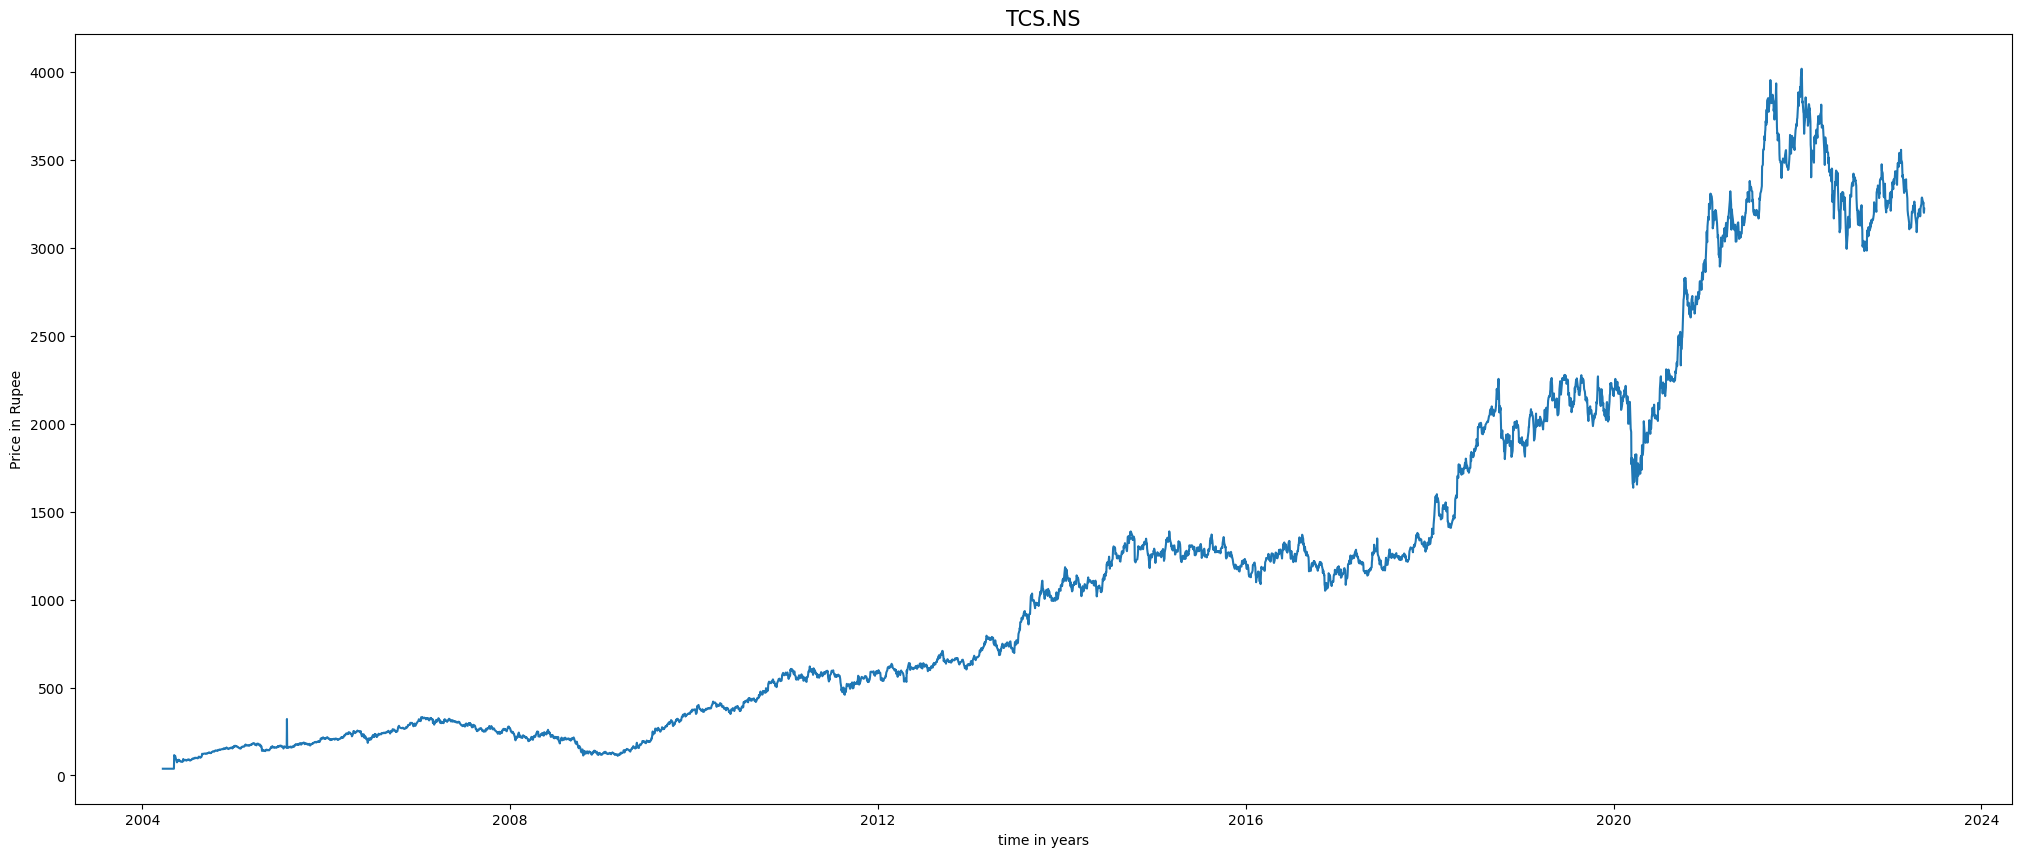

In [3]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()
data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
#data= pd.read_csv(r'C:\Users\DELL\OneDrive\Desktop\minor project\file1.csv')# reading stored csv when internet not available
#data.to_csv(r'C:\Users\DELL\OneDrive\Desktop\minor project\file1.csv')  # saving the dataframe on the computer
print(data.head())
print(data.tail())
plt.figure(figsize=(25,10))
plt.plot(data['close'])
plt.title(symbol,fontsize=15)
plt.ylabel('Price in Rupee')
plt.xlabel('time in years')                   
plt.show()

In [4]:
data.shape

(4740, 6)

In [5]:
data.drop(data[(data['volume']==0)].index, inplace=True) #those records when stock market is closed are removed

In [6]:
data.shape 

(4695, 6)

In [7]:
data = data.dropna()
data.isnull().sum()

open         0
high         0
low          0
close        0
Adj Close    0
volume       0
dtype: int64

In [8]:
data.describe()

,open,high,low,close,Adj Close,volume
count,4695.000000,4695.000000,4695.000000,4695.000000,4695.000000,4.695000e+03
mean,1194.254910,1206.841536,1180.615431,1193.609143,1080.846747,3.523053e+06
std,1047.600441,1056.623477,1037.479420,1046.991740,1032.171504,3.183583e+06
min,77.500000,79.224998,71.525002,74.537498,53.481117,4.560000e+03
25%,287.500000,291.300003,281.393753,286.412491,211.962128,1.874396e+06
50%,1022.500000,1036.000000,1010.599976,1022.000000,839.334290,2.719816e+06
75%,1851.000000,1871.025024,1821.000000,1844.875000,1696.200012,4.189694e+06
max,4033.949951,4043.000000,3980.000000,4019.149902,3885.789551,8.806715e+07


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4695 entries, 2004-05-06 to 2023-05-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4695 non-null   float64
 1   high       4695 non-null   float64
 2   low        4695 non-null   float64
 3   close      4695 non-null   float64
 4   Adj Close  4695 non-null   float64
 5   volume     4695 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 256.8 KB


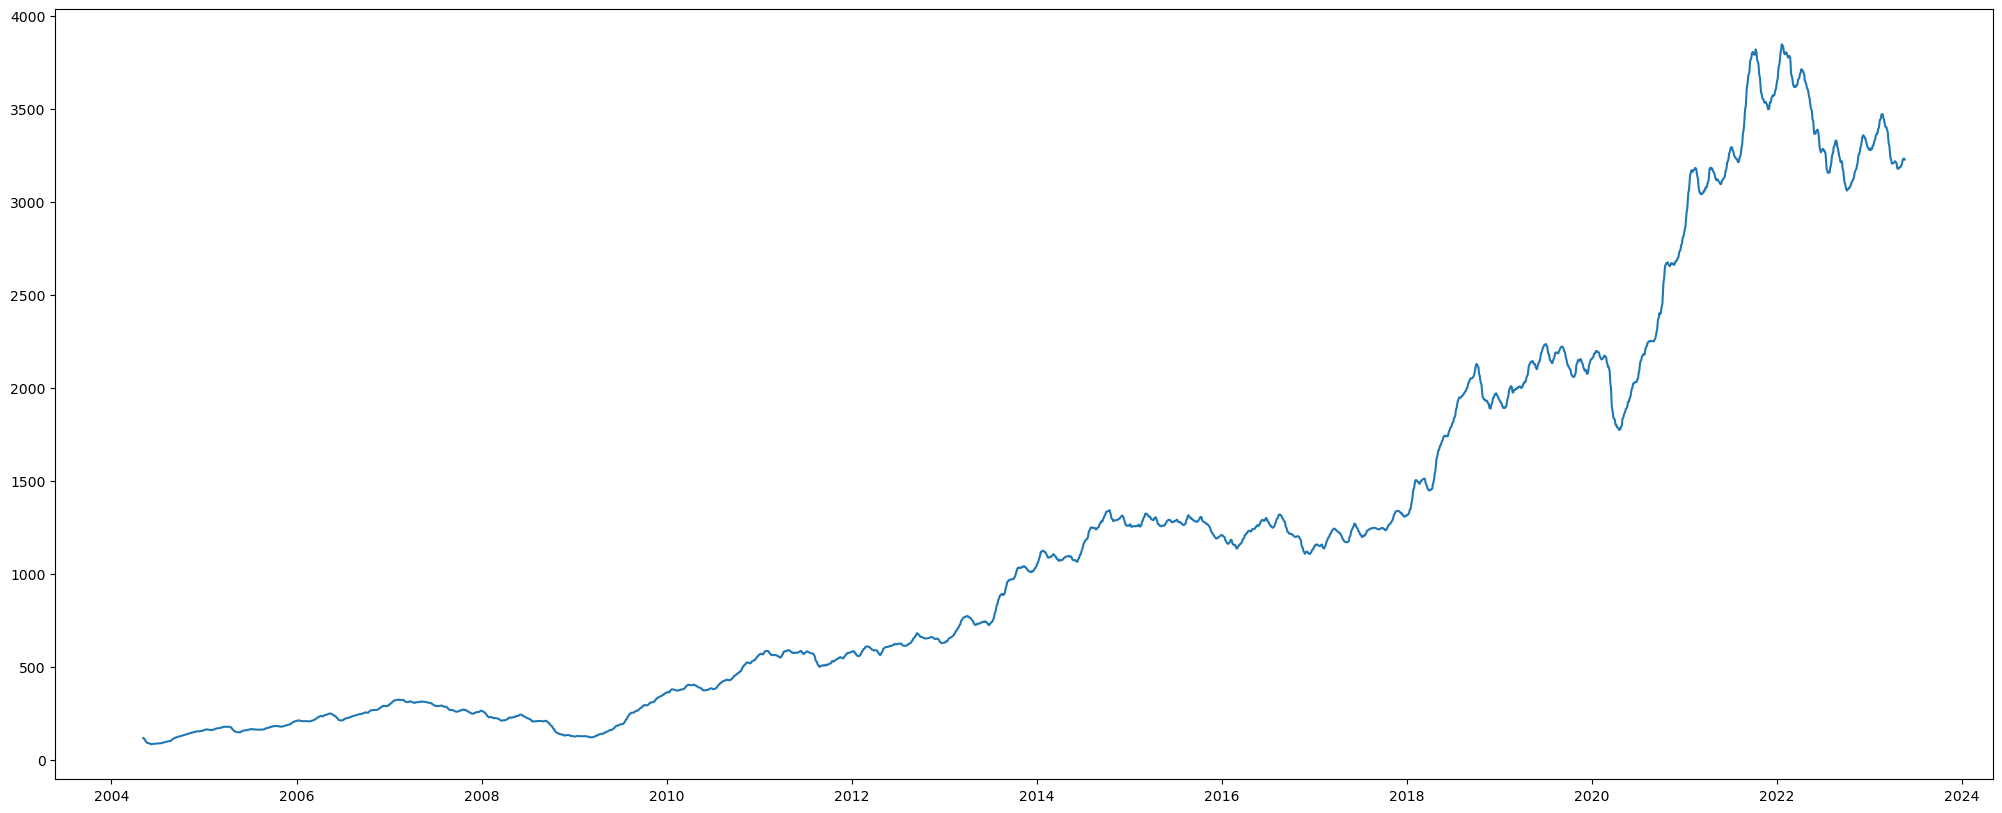

In [10]:
def _exponential_smooth(data, alpha):
    #Function that exponentially smooths dataset so values are less 'rigid'
    return data.ewm(alpha=alpha).mean()
data = _exponential_smooth(data, 0.1)
tmp1 = data.iloc[-7000:]
plt.figure(figsize=(25,10))
plt.plot(tmp1['close'])

In [11]:
def _get_indicator_data(data):
    
    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    #Calculating Exponential moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()  
    data['ema15'] = data['close'] / data['close'].ewm(14).mean() 
    data['ema5'] = data['close'] / data['close'].ewm(5).mean() 
    data['ema3'] = data['close'] / data['close'].ewm(3).mean()    
    
    #Calculating Exponential moving averages for features
    data['50 SMA'] = data['close'].shift(1).rolling(window=50).mean()
    data['21 SMA'] = data['close'].shift(1).rolling(window=21).mean()
    data['14 SMA'] = data['close'].shift(1).rolling(window=14).mean()
    data['5 SMA'] = data['close'].shift(1).rolling(window=5).mean() 
    data['3 SMA'] = data['close'].shift(1).rolling(window=3).mean()
    

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    
    # add more featues
    data['High-Low'] = data['high'] - data['low']
    data['Open-Close'] = data['close'] - data['open']
    data['Std_dev'] = data['close'].rolling(5).std()
    
    return data

data = _get_indicator_data(data)
print(data.columns)
data = data.dropna()
data.tail(10) 

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', '14 period RSI',
       'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV', '14 period ATR', 'MOM',
       '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm',
       'VIp', 'ema50', 'ema21', 'ema15', 'ema5', 'ema3', '50 SMA', '21 SMA',
       '14 SMA', '5 SMA', '3 SMA', 'normVol', 'High-Low', 'Open-Close',
       'Std_dev'],
      dtype='object')


,open,high,low,close,Adj Close,volume,14 period RSI,MACD,SIGNAL,14 period STOCH %K,...,ema3,50 SMA,21 SMA,14 SMA,5 SMA,3 SMA,normVol,High-Low,Open-Close,Std_dev
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-08,3196.718255,3217.801490,3174.636631,3200.231005,3200.204054,2.175294e+06,36.962002,-21.860214,-29.436387,64.737110,...,1.002665,3289.977929,3195.642757,3186.993363,3189.056611,3190.849112,0.926897,43.164859,3.512749,5.333909
2023-05-09,3202.306439,3225.821341,3181.772968,3208.532904,3208.508649,2.068502e+06,44.404306,-18.971262,-27.343362,78.647629,...,1.003945,3284.575735,3195.369672,3186.461526,3192.176946,3195.164201,0.899168,44.048373,6.226465,8.386026
2023-05-10,3211.075796,3233.889207,3190.200676,3216.359619,3216.337789,2.017650e+06,50.354995,-15.867288,-25.048147,80.311611,...,1.004788,3279.305661,3195.330799,3187.072159,3196.262249,3201.132783,0.895409,43.688531,5.283823,10.435159
2023-05-11,3220.868216,3241.470281,3198.380608,3222.938647,3222.919000,1.987848e+06,54.740345,-12.729752,-22.584468,80.819337,...,1.005123,3274.234195,3195.610576,3189.030299,3202.077025,3208.374509,0.899853,43.089673,2.070431,11.520325
2023-05-12,3226.696385,3246.323253,3204.542548,3228.074787,3228.057105,1.891811e+06,57.869218,-9.716781,-20.010931,82.015759,...,1.005035,3269.431075,3195.951661,3192.059410,3208.539323,3215.943723,0.877381,41.780706,1.378403,11.130013
2023-05-15,3232.426746,3250.890928,3208.923303,3230.772313,3230.756400,1.817669e+06,59.454593,-7.030270,-17.414799,80.979313,...,1.004400,3264.829267,3196.546733,3195.595967,3215.227392,3222.457684,0.865647,41.967625,-1.654433,9.023682
2023-05-16,3234.804067,3254.301835,3213.075967,3233.510072,3233.495750,1.734532e+06,61.056303,-4.626941,-14.857227,80.309909,...,1.003933,3260.396839,3197.146108,3199.352083,3221.335654,3227.261916,0.850717,41.225868,-1.293994,6.805175
2023-05-17,3236.918655,3256.871652,3211.593371,3231.029060,3231.016170,1.719961e+06,58.789769,-2.889177,-12.463617,75.613424,...,1.002370,3256.260255,3198.015544,3203.319372,3226.331088,3230.785724,0.866152,45.278281,-5.889595,4.026285
2023-05-18,3235.821785,3254.079481,3209.934034,3227.911164,3227.899563,1.684901e+06,55.977464,-1.743478,-10.319589,71.449404,...,1.001052,3252.329028,3199.127560,3206.965289,3229.264976,3231.770482,0.870477,44.145448,-7.910621,2.329650


In [12]:
#data.to_csv(r'C:\Users\DELL\OneDrive\Desktop\minor project\file2.csv') # saving the dataframe having indicators

<Axes: >

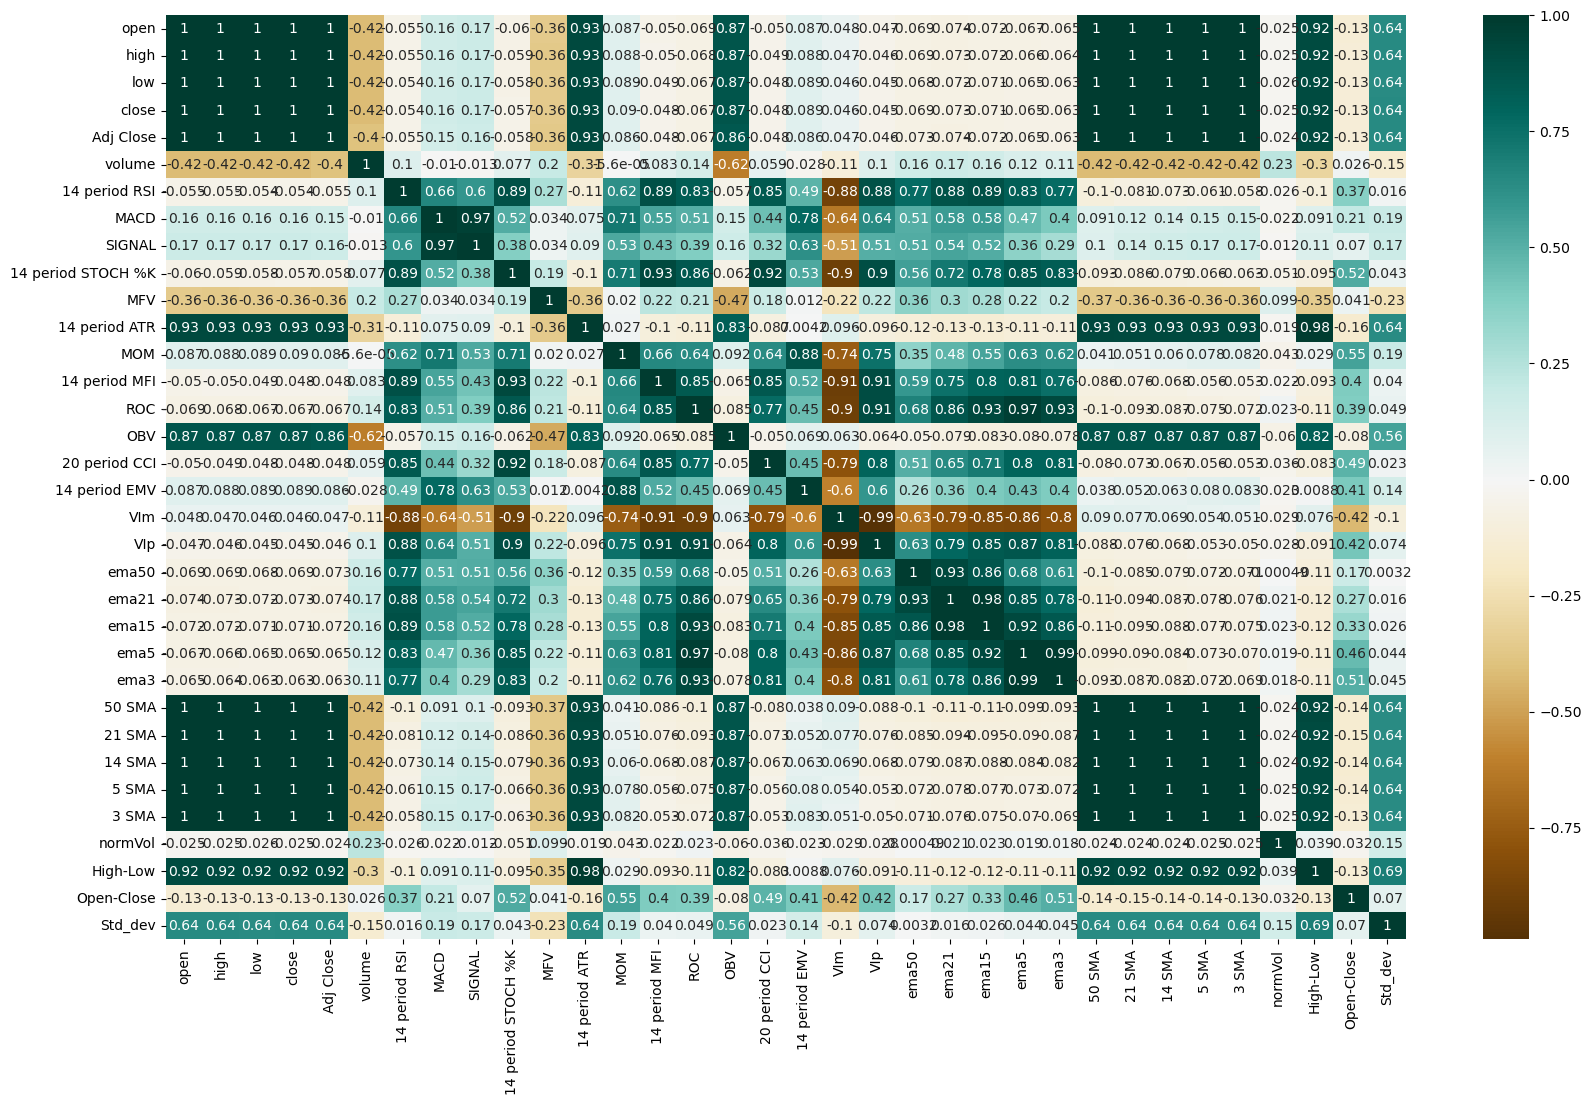

In [13]:
fig,ax=plt.subplots(figsize=(20,12))
sns.heatmap(data.corr(),center=0,cmap='BrBG',annot=True)

In [14]:
del(data['open'])
del(data['high'])
del(data['low'])
del(data['volume'])
del(data['Adj Close'])
del(data['20 period CCI'])
del(data['3 SMA'])
del(data['5 SMA'])
del(data['14 SMA'])
del(data['50 SMA'])

<Axes: >

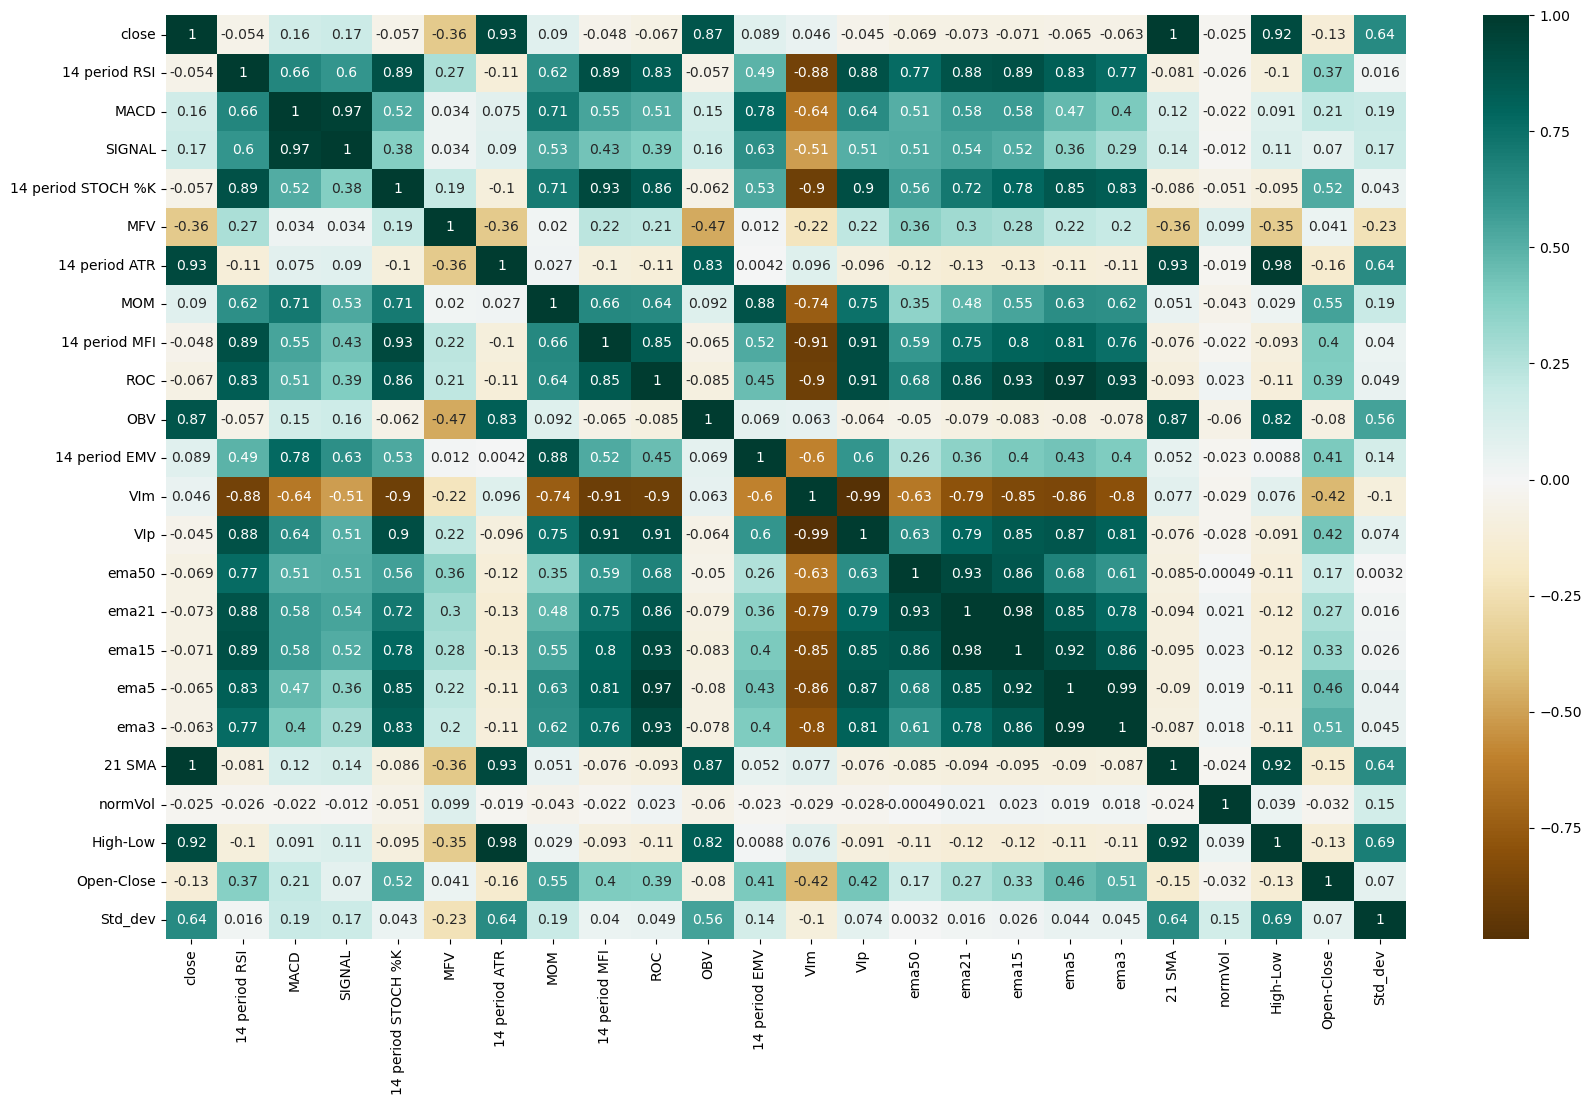

In [15]:
fig,ax=plt.subplots(figsize=(20,12))
sns.heatmap(data.corr(),center=0,cmap='BrBG',annot=True)

In [16]:
data.shape

(4645, 24)

In [17]:
# Apply feature scaling
scaler = StandardScaler()
data[data.columns[:]] = scaler.fit_transform(data[data.columns[:]])
data.tail(10)

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,ema50,ema21,ema15,ema5,ema3,21 SMA,normVol,High-Low,Open-Close,Std_dev
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-08,1.919507,-0.787740,-1.343263,-1.798379,0.311087,-0.832990,1.276471,0.347073,-0.122085,-0.170045,...,-0.739473,-0.635054,-0.491541,-0.082500,0.034990,1.928766,-0.531669,0.805036,0.886702,0.074018
2023-05-09,1.927471,-0.546060,-1.197282,-1.688210,0.837792,-0.825111,1.220578,0.548978,0.081912,-0.033933,...,-0.704464,-0.569676,-0.410225,0.029175,0.162485,1.928503,-0.732359,0.847401,1.467347,0.574504
2023-05-10,1.934980,-0.352819,-1.040435,-1.567399,0.900797,-0.818051,1.160594,0.736160,0.294802,0.045868,...,-0.671792,-0.510198,-0.338265,0.113963,0.246491,1.928465,-0.759560,0.830146,1.265653,0.910520
2023-05-11,1.941292,-0.210410,-0.881893,-1.437720,0.920021,-0.813126,1.107539,0.842271,0.513121,0.102479,...,-0.644170,-0.461268,-0.281532,0.163409,0.279959,1.928735,-0.727400,0.801431,0.578094,1.088466
2023-05-12,1.946219,-0.108803,-0.729644,-1.302258,0.965322,-0.808887,1.048177,0.943239,0.732852,0.146062,...,-0.622201,-0.423663,-0.240660,0.180240,0.271192,1.929063,-0.890039,0.738666,0.430023,1.024462
2023-05-15,1.948807,-0.057320,-0.593893,-1.165608,0.926078,-0.807560,0.990903,0.916501,0.952974,0.151326,...,-0.609330,-0.403187,-0.222915,0.153395,0.207864,1.929636,-0.974960,0.747628,-0.218904,0.679067
2023-05-16,1.951434,-0.005307,-0.472450,-1.030987,0.900732,-0.807826,0.936199,0.899301,1.177694,0.167001,...,-0.596559,-0.383381,-0.206030,0.131692,0.161341,1.930213,-1.083012,0.712061,-0.141782,0.315276
2023-05-17,1.949053,-0.078910,-0.384639,-0.904996,0.722906,-0.812138,0.905722,0.860672,1.007878,0.115118,...,-0.602621,-0.397505,-0.233872,0.026609,0.005580,1.931050,-0.971302,0.906375,-1.125088,-0.140406
2023-05-18,1.946062,-0.170236,-0.326746,-0.792143,0.565240,-0.817676,0.880157,0.710391,0.834007,0.061231,...,-0.610839,-0.415023,-0.265164,-0.071415,-0.125814,1.932120,-0.940005,0.852055,-1.557520,-0.418620


In [18]:
live_pred_data = data.iloc[-20:-15]  #data of last 15-20 days from today
live_pred_data.head(5)

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,...,ema50,ema21,ema15,ema5,ema3,21 SMA,normVol,High-Low,Open-Close,Std_dev
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-21,1.898719,-1.602881,-2.228627,-2.435614,-0.964391,-0.896928,1.543124,-0.873314,-0.798907,-0.487788,...,-0.888795,-0.992834,-0.969285,-0.749316,-0.715407,1.958612,0.630611,1.563418,-0.077586,1.252759
2023-04-24,1.898358,-1.604469,-2.193551,-2.405553,-0.925901,-0.890900,1.553094,-0.908477,-0.817088,-0.485524,...,-0.881893,-0.966748,-0.929552,-0.672757,-0.603487,1.952389,0.288744,1.543371,0.450782,0.728040
2023-04-25,1.898148,-1.605456,-2.144673,-2.371322,-0.933866,-0.884434,1.556096,-1.036676,-0.831795,-0.514303,...,-0.874560,-0.940794,-0.891053,-0.606160,-0.515672,1.946933,0.128638,1.472103,0.269436,-0.039100
2023-04-26,1.900085,-1.534024,-2.076521,-2.329739,-0.860350,-0.877866,1.550584,-0.985125,-0.632527,-0.507102,...,-0.859439,-0.901894,-0.836406,-0.512909,-0.397176,1.942343,0.001048,1.329803,0.622953,-0.613253
2023-04-27,1.900849,-1.504736,-1.998972,-2.280316,-0.831341,-0.871150,1.528263,-1.027254,-0.608698,-0.542834,...,-0.848920,-0.872349,-0.795434,-0.455631,-0.336894,1.938520,0.015697,1.207248,0.637286,-0.599462


In [19]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15) # prediciting the value 15 day ahead
data = data.dropna()
data.tail(15)
del (data['close'])

In [21]:
def cross_Validation(data):
    num_train = 10  # Increment of how many starting points(len(data) / num_train  =  number of train-test sets)
    len_train = 30  # Length of each train-test set

    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    gbt_RESULTS = []
    ensemble_RESULTS = []
    lr_RESULTS = []
    svm_RESULTS = []
    dt_RESULTS = []

    i = 0

    while True:
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train: (i * num_train) + len_train]
        i += 1

        if len(df) < len_train:
            break

        y = df['pred']
        features = [x for x in df.columns if x != 'pred']
        X = df[features]

        if len(set(y)) < 2:
            continue  # Skip this iteration if there is only one class in y

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=9 * len(X) // 10, shuffle=False)

        if len(set(y_train)) < 2:
            continue  # Skip this iteration if there is only one class in y_train

        # Create the models
        rf = RandomForestClassifier()
        knn = KNeighborsClassifier()
        gbt = GradientBoostingClassifier()
        lr = LogisticRegression()
        svm = SVC(probability=True)  # Set probability to True for SVC
        dt = DecisionTreeClassifier()

        # Create the ensemble model
        estimators = [('knn', knn), ('rf', rf), ('gbt', gbt), ('lr', lr), ('svm', svm), ('dt', dt)]
        ensemble = VotingClassifier(estimators, voting='soft')

        # Fit models
        rf.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        gbt.fit(X_train, y_train)
        lr.fit(X_train, y_train)
        svm.fit(X_train, y_train)
        dt.fit(X_train, y_train)
        ensemble.fit(X_train, y_train)

        # Get predictions
        rf_prediction = rf.predict(X_test)
        knn_prediction = knn.predict(X_test)
        gbt_prediction = gbt.predict(X_test)
        lr_prediction = lr.predict(X_test)
        svm_prediction = svm.predict(X_test)
        dt_prediction = dt.predict(X_test)
        ensemble_prediction = ensemble.predict(X_test)

        # Determine accuracy and append to results
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        gbt_accuracy = accuracy_score(y_test.values, gbt_prediction)
        lr_accuracy = accuracy_score(y_test.values, lr_prediction)
        svm_accuracy = accuracy_score(y_test.values, svm_prediction)
        dt_accuracy = accuracy_score(y_test.values, dt_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)

        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        gbt_RESULTS.append(gbt_accuracy)
        lr_RESULTS.append(lr_accuracy)
        svm_RESULTS.append(svm_accuracy)
        dt_RESULTS.append(dt_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)

    print('RF Accuracy = ' + str(sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str(sum(knn_RESULTS) / len(knn_RESULTS)))
    print('GBT Accuracy = ' + str(sum(gbt_RESULTS) / len(gbt_RESULTS)))
    print('LR Accuracy = ' + str(sum(lr_RESULTS) / len(lr_RESULTS)))
    print('SVM Accuracy = ' + str(sum(svm_RESULTS) / len(svm_RESULTS)))
    print('DT Accuracy = ' + str(sum(dt_RESULTS) / len(dt_RESULTS)))
    print('Ensemble Accuracy = ' + str(sum(ensemble_RESULTS) / len(ensemble_RESULTS)))

    # Return the ensemble model
    return ensemble

# Call the cross_Validation function and pass your data1 as an argument
ensemble = cross_Validation(data)

RF Accuracy = 0.8869863013698628
KNN Accuracy = 0.7465753424657535
GBT Accuracy = 0.867579908675799
LR Accuracy = 0.7557077625570775
SVM Accuracy = 0.7100456621004565
DT Accuracy = 0.8105022831050229
Ensemble Accuracy = 0.8641552511415526


In [22]:
#verification of results
if 'close' in live_pred_data:
    del live_pred_data['close']
prediction = ensemble.predict(live_pred_data)
print(prediction)

[1. 1. 1. 1. 1.]
